<font color='tomato'><font color="#CC3D3D"><p>
# NCF using Implicit Ratings

### Import modules

In [1]:
import pandas as pd
import numpy as np
import pickle, random, os, sys
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.13.0


### Set random seeds to make your results reproducible

In [2]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")

reset_seeds()

RANDOM SEEDS RESET


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1: Load and process the data

##### Read data

In [4]:
# 도서판매 트랜잭션을 Negative Sampling을 통해 Implicit 학습/평가 데이터로 변환한 데이터
train, test = pd.read_pickle('/content/drive/Othercomputers/mypc/study/10_RecSystem/실습-20231007/binary_ratings.pkl')

print(train.shape,test.shape)
train.head()

(340475, 3) (72825, 3)


,USER,ITEM,RATING
0,11722,48651,1.0
1,11722,28072,0.0
2,11722,56986,1.0
3,11722,63497,0.0
4,11722,28576,1.0


### Step 2: Define the model architecture

##### Stack layers from input to output

In [16]:
# Variable 초기화
K = 8                      # Latent factor 수
M = train.USER.max() + 1   # Number of users
N = train.ITEM.max() + 1   # Number of items

M, N

(26607, 65999)

In [17]:
# Input layer
user = keras.Input(shape=(1, ))
item = keras.Input(shape=(1, ))

# Embedding layer
MF_Embedding_User = keras.layers.Embedding(M, K)(user)
MF_Embedding_Item = keras.layers.Embedding(N, K)(item)

MLP_Embedding_User = keras.layers.Embedding(M, 8)(user)  # 8 => NCF 논문 구현체 참고
MLP_Embedding_Item = keras.layers.Embedding(N, 8)(item)

# GMF part
user_latent = keras.layers.Flatten()(MF_Embedding_User)
item_latent = keras.layers.Flatten()(MF_Embedding_Item)

gmf_output = keras.layers.Multiply()([user_latent, item_latent]) # element-wise product

# MLP part
user_latent = keras.layers.Flatten()(MLP_Embedding_User)
item_latent = keras.layers.Flatten()(MLP_Embedding_Item)

x = keras.layers.Concatenate()([user_latent, item_latent])
x = keras.layers.Dense(16, activation='leaky_relu')(x)  # 최신 activation 함수로 변경
x = keras.layers.Dense(8, activation='leaky_relu')(x)  # 최신 activation 함수로 변경
mlp_output = keras.layers.Dense(4, activation='leaky_relu')(x)

# Concatenate MF and MLP parts
x = keras.layers.Concatenate()([gmf_output, mlp_output])
x = keras.layers.Dropout(0.3)(x)   # 과대적합을 줄이기 위해 Dropout 추가

# Final prediction layer
output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=[user, item], outputs=output)

##### Summarize & visualize the model

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 8)                 212856    ['input_3[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 1, 8)                 527992    ['input_4[0][0]']             
                                                                                            

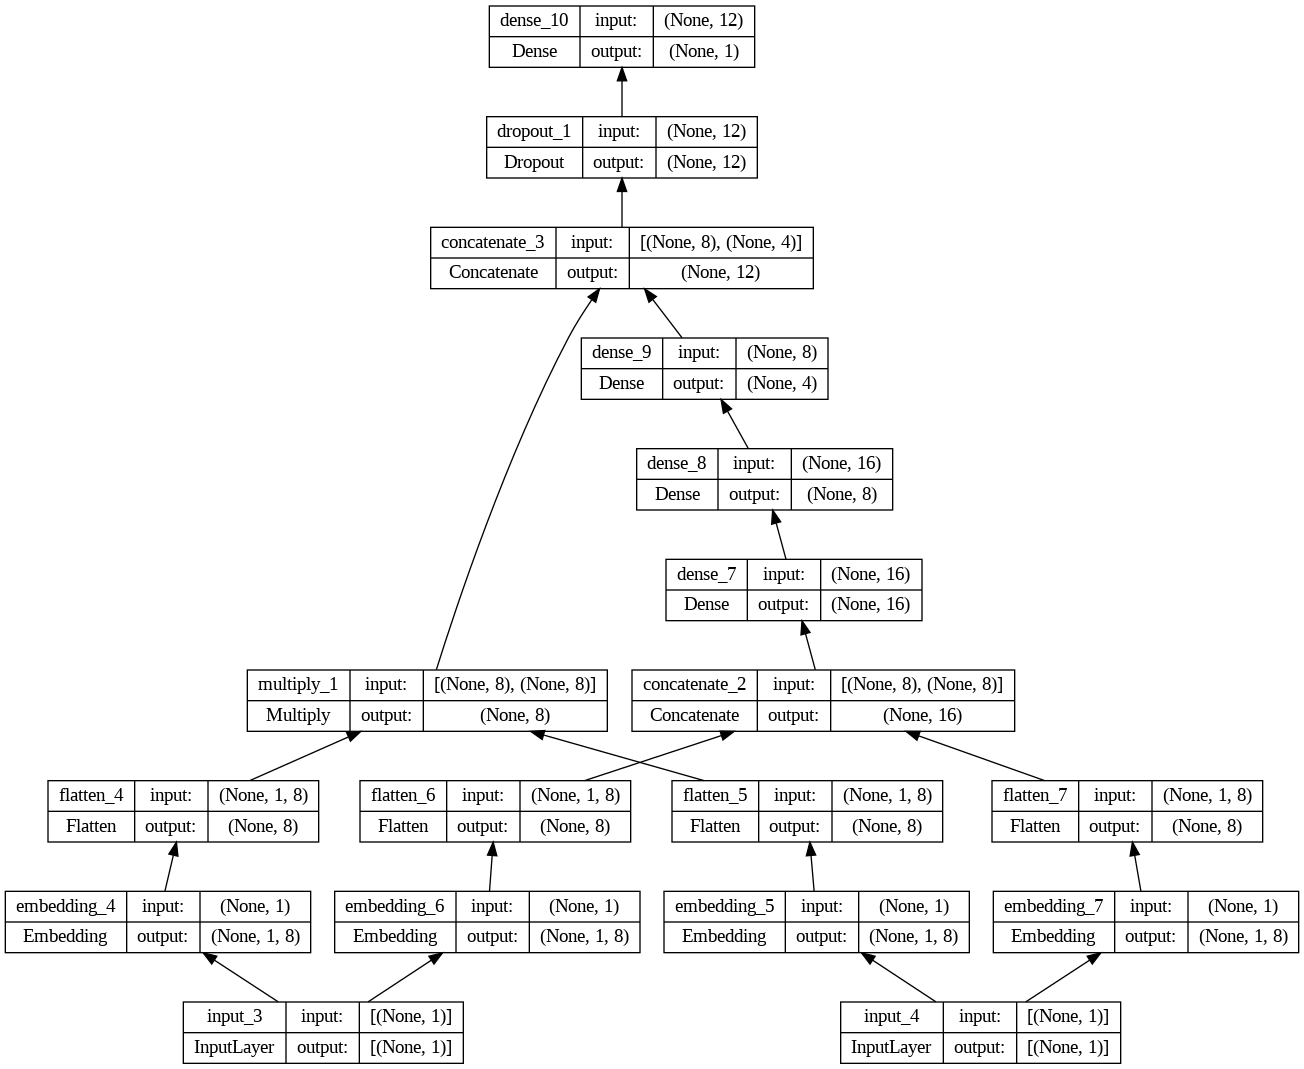

In [19]:
# 연결 그래프 시각화
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="BT")

### Step 3: Choose the optimizer and the cost function

In [20]:
# loss, optimizer, metrics 설정
model.compile(
    loss='binary_crossentropy',                  # 이진분류를 위한 손실함수
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), # 옵티마이저 변경
    metrics=["accuracy"]
)

### Step 4: Train the model

##### Set learning conditions & fit the model

In [21]:
hist = model.fit(
    x=[train.USER, train.ITEM],
    y=train.RATING,
    validation_split=0.1,
    batch_size=256,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
    shuffle=False,
    verbose=2
)

Epoch 1/20
1197/1197 - 24s - loss: 0.6321 - accuracy: 0.6194 - val_loss: 0.5161 - val_accuracy: 0.7487 - 24s/epoch - 20ms/step
Epoch 2/20
1197/1197 - 4s - loss: 0.4562 - accuracy: 0.8090 - val_loss: 0.4403 - val_accuracy: 0.8226 - 4s/epoch - 3ms/step
Epoch 3/20
1197/1197 - 4s - loss: 0.3982 - accuracy: 0.8540 - val_loss: 0.4169 - val_accuracy: 0.8432 - 4s/epoch - 4ms/step
Epoch 4/20
1197/1197 - 4s - loss: 0.3765 - accuracy: 0.8656 - val_loss: 0.4091 - val_accuracy: 0.8510 - 4s/epoch - 4ms/step
Epoch 5/20
1197/1197 - 4s - loss: 0.3633 - accuracy: 0.8695 - val_loss: 0.4072 - val_accuracy: 0.8532 - 4s/epoch - 4ms/step
Epoch 6/20
1197/1197 - 4s - loss: 0.3540 - accuracy: 0.8716 - val_loss: 0.4111 - val_accuracy: 0.8535 - 4s/epoch - 4ms/step
Epoch 7/20
1197/1197 - 4s - loss: 0.3440 - accuracy: 0.8736 - val_loss: 0.4184 - val_accuracy: 0.8518 - 4s/epoch - 4ms/step
Epoch 8/20
1197/1197 - 4s - loss: 0.3347 - accuracy: 0.8751 - val_loss: 0.4276 - val_accuracy: 0.8484 - 4s/epoch - 4ms/step


##### Visualize training history

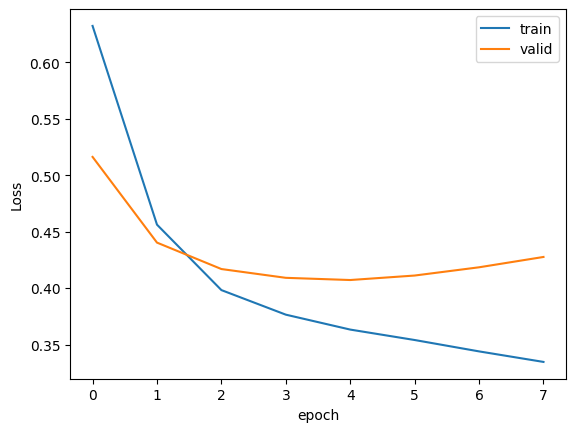

In [22]:
# Plot RMSE

plt.plot(hist.history['loss'], label="train")
plt.plot(hist.history['val_loss'], label="valid")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2276/2276 [==============================] - 3s 1ms/step


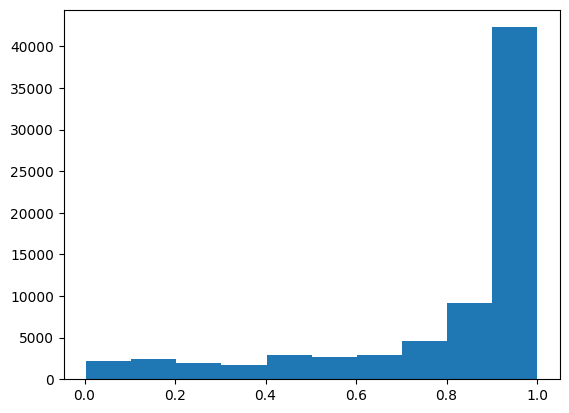

In [23]:
# 예측 rating(0~1) 빈도 도식화
plt.hist(model.predict([test.USER, test.ITEM]))
plt.show()

### Step 5: Make recommendations

##### Make top-K recommendations

In [26]:
top_k = 10        # 추천 아이템 갯수
test_users = 100  # 추천 대상자 수

# 예측을 위해 아이템수만큼 사용자 ID를 복제하는 과정
target_users = []
target_items = []
for u in np.sort(test.USER.unique()[:test_users]):
    for i in test.ITEM.unique():
        target_users.append(u)
        target_items.append(i)
target_users = np.array(target_users)
target_items = np.array(target_items)

# 예측 스코어를 얻고 평가를 위한 데이터프레임 형식으로 변환하는 과정
pred_scores = model.predict([target_users, target_items]).flatten()
recommendations = (pd.DataFrame({'USER':target_users, 'ITEM':target_items, 'SCORE':pred_scores})
                   .sort_values(by=['USER','SCORE'], ascending=False)
                   .groupby('USER')
                   .head(top_k))
recommendations

101225/101225 [==============================] - 158s 2ms/step


,USER,ITEM,SCORE
3206862,26547,22688,0.999955
3207250,26547,22782,0.999867
3208024,26547,17891,0.999855
3207290,26547,22728,0.999824
3206992,26547,22806,0.999802
...,...,...,...
433,287,15009,0.999731
203,287,35700,0.999694
144,287,22692,0.999663
1070,287,22690,0.999660


##### Evaluate the recommendation performance

In [27]:
# Hit List
pd.merge(recommendations, test, on=['USER','ITEM'])

,USER,ITEM,SCORE,RATING
0,26350,22688,0.999537,1.0
1,26350,22782,0.998621,1.0
2,26350,22728,0.998176,1.0
3,26350,22690,0.997348,1.0
4,16834,22688,0.999941,1.0
5,16834,17891,0.999809,1.0
6,9832,22782,0.998944,1.0
7,9832,22806,0.998431,1.0
8,9832,22692,0.997989,1.0
9,7121,22692,0.999903,1.0


In [28]:
# MS Recommender 패키지에서 제공하는 추천시스템 평가함수
sys.path.append('/content/drive/Othercomputers/mypc/study/10_RecSystem') # 빈셀에서 pwd를 실행한 결과를 path로 입력
from msr.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

args = [test, recommendations]
kwargs = dict(col_user='USER',
              col_item='ITEM',
              col_rating='RATING',
              col_prediction='SCORE',
              relevancy_method='top_k',
              k=10)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

print(f"Model: NCF",
      f"Precision@{top_k}:\t {eval_precision:f}",
      f"Recall@{top_k}:\t {eval_recall:f}",
      f"MAP@{top_k}:\t\t {eval_map:f}",
      f"NDCG@{top_k}:\t {eval_ndcg:f}", sep='\n')

Model: NCF
Precision@10:	 0.014000
Recall@10:	 0.012790
MAP@10:		 0.006289
NDCG@10:	 0.018613


<font color="#CC3D3D"><p>
# End